<a href="https://colab.research.google.com/github/ramanathanlab/genslm/blob/main/examples/generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# NOTE: You may need to run this twice due to a pip dependency conflict
!pip install git+https://github.com/ramanathanlab/genslm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ramanathanlab/genslm to /tmp/pip-req-build-3222q863
  Running command git clone -q https://github.com/ramanathanlab/genslm /tmp/pip-req-build-3222q863
  Cloning https://github.com/maxzvyagin/transformers to /tmp/pip-install-k_9gz20w/transformers_f804a482b2c84233b81b363bb7ed240d
  Running command git clone -q https://github.com/maxzvyagin/transformers /tmp/pip-install-k_9gz20w/transformers_f804a482b2c84233b81b363bb7ed240d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [11]:
!ls gdrive/MyDrive/patric_25m_epoch01-val_loss_0.57_bias_removed.pt
# This currently requires you to download the 25M model weights from Globus

gdrive/MyDrive/patric_25m_epoch01-val_loss_0.57_bias_removed.pt


In [15]:
import torch
from genslm import GenSLM

# Load model
#model = GenSLM("genslm_25M_patric", model_cache_dir="/content/gdrive/MyDrive")
model = GenSLM("genslm_2.5B_patric", model_cache_dir="/home/xlian/genslm_models/2.5B")
model.eval()

# Select GPU device if it is available, else use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Prompt the language model with a start codon
prompt = model.tokenizer.encode("MPAG", return_tensors="pt").to(device)

tokens = model.model.generate(
    prompt,
    max_length=10,  # Increase this to generate longer sequences
    min_length=10,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=2,  # Change the number of sequences to generate
    remove_invalid_values=True,
    use_cache=True,
    pad_token_id=model.tokenizer.encode("[PAD]")[0],
    temperature=1.0,
)

sequences = model.tokenizer.batch_decode(tokens, skip_special_tokens=True)

for sequence in sequences:
    print(sequence)

GAA GCA GCG CAA AAA ACG CTC GTC GAA
CTG TTT GGT CGC AGC GGC GAA GAG CAC


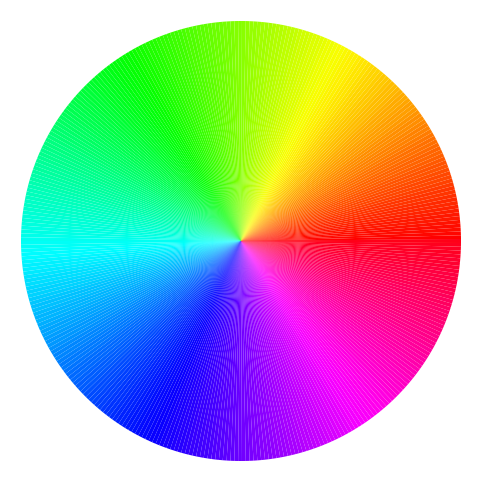

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': 'polar'})

# Generate colors
num_colors = 360
angles = np.linspace(0, 2 * np.pi, num_colors)
colors = [plt.cm.hsv(i / num_colors) for i in range(num_colors)]

# Draw color wheel
for i, angle in enumerate(angles):
    ax.bar(angle, 1, width=2*np.pi/num_colors, color=colors[i], bottom=0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.show()
